In [45]:
from editor import Editor

editor = Editor()
editor.load('creatures/two_legs.json')
editor.run()

File saved as: creatures/two_legs.json


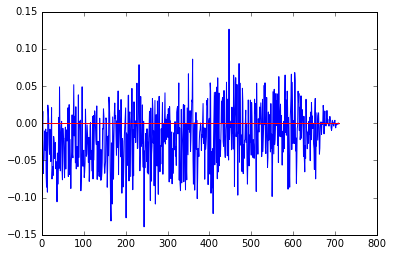

episode: 710 variance: 0.2 learning_rate: 0.001


In [46]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output
from engine import Engine
from pyglet.window import key
import util

# train your model to (hopefully) walk by running this cell

# hit s to speed up training, and s again to watch the best set of weights
# use the up and down arrow keys to introduce more or less randomness in sampled torques

# this cell is an experiment with policy improvement
# the agent's joint torques (continuous, action) are randomly sampled from means output by a neural network
# the gradient which will shift the means given the state, is accumulated into a decaying single gradient
# if the agent experiences a large reward, we add the gradient to its weights, "reinforcing" the recent behavior
# in the case of a negative reward, we subtract the gradient, inhibiting recent behavior (hopefully!)

FILE = 'creatures/two_legs.json'

# Physics engine and window
LOWER_LIM = -.1 * np.pi
UPPER_LIM = .1 * np.pi
LIMIT = True
ANGLE_RANGE = UPPER_LIM - LOWER_LIM if LIMIT else np.pi*2.0

engine = Engine(caption='Train', width=1280, height=720, ppm=15, gravity=(0, -50), joint_limit=LIMIT, \
               upper_angle=UPPER_LIM, lower_angle=LOWER_LIM, max_torque=10000, \
                linear_damping=0.0, angular_damping=0.0)

# step floor
def add_steps(steps=8):
    offset = engine.width/steps
    for i in range(steps+1):
        engine.add_static_body((i * offset, 45), (10, 20))

# Load creature
engine.load(FILE)

# count joints and body parts
body_count = len(engine.bodies)
joint_count = len(engine.joints)

if body_count == 0 or joint_count == 0:
    engine.close()
    raise RuntimeError("Your model doesn't have any physics bodies or joints")

def features(time_step=0):
    f = []
    
    for j in engine.joints:
        a = j.angle
        r = (j.upperLimit - j.lowerLimit) if j.limitEnabled else np.pi*2.0
        a %= r
        a = a * 2.0 - 1.0
        f += [a]
        #f += [np.tanh(j.speed)]
        
    for b in engine.bodies:
        a = b.angle % ANGLE_RANGE
        a /= ANGLE_RANGE
        a = a * 2.0 - 1.0
        f += [a]
        #f += [np.tanh(b.angularVelocity)]
        #f += [np.tanh(b.linearVelocity[0])]
        #f += [np.tanh(b.linearVelocity[1])]
        #f += [np.sin(a)]
        #f += [np.cos(a)]
        #f += [engine.to_window(b.position)[1]/engine.height]
        #f += [engine.to_window(b.position)[0]/engine.width]
        
        # collision
        if len(b.contacts) > 0:
            f += [1.0]
        else:
            f += [0.0]
    
    #f += [np.sin(time_step / 2.0)] # Creature's heartbeat? :-)
    #f += [np.cos(time_step / 2.0)]
    #f += [np.sin(time_step)]
    f += [1] # bias
    return np.array([f])

# tanh:
act = lambda x: np.tanh(x)
act_p = lambda x: 1.0 - np.tanh(x)**2

# rect linear:
#act = lambda x: x * (x > 0)
#act_p = lambda x: (x > 0).astype(np.float)

# soft_plus:
#act = lambda x: np.log(1+np.exp(x))
#act_p = lambda x: np.exp(x)/(1+np.exp(x))

# sparse:
"""
sparsity = 28
def act(x):
    x = x.copy()
    idx = np.argpartition(x, sparsity)[0, :sparsity]
    x[0, idx] = 0
    return x

def act_p(x):
    idx = np.argpartition(x, sparsity)[0, :sparsity]
    mask = np.ones_like(x)
    mask[0, idx] = 0
    return mask
"""

def cols_as_dist(W):
    return np.exp(W)/np.sum(np.exp(W), axis=0)

TIMESTEPS = 256 # timesteps per episode
PHYS_STEPS = 20
total_r = 0.0
episode = 0
learning_rate = .001
variance = 3 # increase or decrease deviation from means output by nn

FEATURES = features().shape[1]
IN = 32

W1 = np.random.randn(IN, IN) # initial set of weights
W2 = np.random.randn(FEATURES, IN)
W3 = np.random.randn(IN, joint_count)

rs = []
avg_r = 0
avg_r_ts = 0

speedup = False
running = True
interacted = False

while running:
    if not interacted:
        rs += [total_r/TIMESTEPS]
        
    if len(rs) >= 10:
        avg_r = np.sum(rs[-10:])/10.0
    
    if episode % 10 == 0:
        clear_output(wait=True)
        
        if len(rs) > 1000:
            rs = rs[-1000:]
        fig = plt.plot(rs, 'b')
        plt.plot([0, len(rs)], [0, 0], 'r')
        plt.show()
        
        print('episode: {} variance: {} learning_rate: {}'.format(episode, np.round(variance, 2), learning_rate))
    
    # new episode
    total_r = 0.0
    t = 0
    episode += 1
    
    engine.clear_all_but_ground()
    engine.load(FILE)
    
    engine.set_position((engine.width/2, engine.height/2))
    
    for j in engine.joints:
        j.motorSpeed = np.random.randn()
    
    engine.step_physics(50)
    for b in engine.bodies:
        b.linearVelocity = (0, 0)
        b.angularVelocity = 0
    
    trace = np.zeros_like(W1)
    h = np.zeros([1, IN])
    
    interacted = False
    reset = False
    while not reset:
        engine.window.dispatch_events()
        
        if engine.exited():
            running = False
            reset = True
                
        # keyboard input
        if engine.window.pressed(key.UP):
            variance += 0.1
        if engine.window.pressed(key.DOWN):
            variance -= 0.1
        if engine.window.pressed(key.S):
            speedup = not speedup
        if engine.window.pressed(key.R):
            reset = True
            W1 = util.randn(W1.shape)
            trace = np.zeros_like(W1)
            
        variance = max(variance, 0.0)
            
        engine.window.reset_keys()
        
        if engine.window.mouse_pressed:
            engine.create_mouse_joint()
            interacted = True
        else:
            engine.destroy_mouse_joint()
        
        engine.update_mouse_joint()
        
        text = 'episode: {} avg reward: {} variance: {}'.format(episode, np.round(avg_r, 2), np.round(variance, 2))
        
        x = h.copy() * .5 #np.zeros([1, IN]) #h.copy()
        fet = features(t)
        sense = fet.dot(W2)
        
        x += sense
        x = act(x)
        
        z1 = x.dot(W1)
        h = act(z1)
        
        torques = act(h.dot(W3))
        
        if variance > 0:
            torques = np.array([[np.random.normal(loc=u, scale=np.sqrt(variance)) for u in torques[0]]])
                    
        start_p = engine.body_position()
        
        for i, j in enumerate(engine.joints):
            j.motorSpeed = torques[0, i]
        
        matrices = [fet.T, W2, sense.T, x.T, W1, trace, h.T, W3, torques.T]
        
        for i in range(PHYS_STEPS):
            engine.step_physics(1)
            if not speedup:
                engine.window.clear()
                engine.window.draw_matrices(matrices, recalc=False)
                engine.window.draw_text(text)
                engine.render()
                engine.clock_tick()
                
        end_p = engine.body_position()
        
        # reward
        reward = (end_p[0] - start_p[0])
        reward /= PHYS_STEPS
        
        total_r += reward
        avg_r_ts += (reward - avg_r_ts) * 0.02
                
        #util.render_matrix(engine.window, np.array([[reward]]), (int(end_p[0]), int(end_p[1])))
        
        if end_p[0] > engine.width/2 + 400:
            engine.set_position((engine.width/2 - 350, end_p[1]), zero_vel=False)
        elif end_p[0] < engine.width/2 - 400:
            engine.set_position((engine.width/2 + 350, end_p[1]), zero_vel=False)
        
        
        # train
        r = reward
        #r = np.tanh(r)
        #r = np.clip(r, -10, 10)
        
        trace += np.multiply(x.T, h)
        
        W1 += trace * (reward - avg_r_ts) * learning_rate
        #W1 = util.normalize(W1)
        #W1 += np.random.randn(W1.shape[0], W1.shape[1]) * 0.0001
        
        trace *= 0.9
        
        if not speedup:
            engine.window.draw_matrices(matrices, recalc=True)
        
        if t > TIMESTEPS and speedup:
            reset = True
            if episode % 10 == 0:
                engine.window.clear()
                engine.window.draw_matrices(matrices)
                engine.window.draw_text(text)
                engine.render()
            
        t += 1

engine.close()

In [38]:
engine.joints[0]

b2RevoluteJoint(active=True,
                anchorA=b2Vec2(41.8941,9.28602),
                anchorB=b2Vec2(41.8941,9.28602),
                angle=-0.35024523735046387,
                bodyA=b2Body(active=True,
                             angle=-0.03270083665847778,
                             angularDamping=0.0,
                             angularVelocity=-3.4791648387908936,
                             awake=True,
                             bullet=False,
                             contacts=[],
                             fixedRotation=False,...  ),
                bodyB=b2Body(active=True,
                             angle=-2.204838991165161,
                             angularDamping=0.0,
                             angularVelocity=-4.5204386711120605,
                             awake=True,
                             bullet=False,...  ),
                limitEnabled=True,
                limits=(-0.6283185482025146, 0.6283185482025146),
                lowerLimit=-

In [18]:
import numpy as np
W = np.random.randn(4, 4)